# Alignment of two Xenium Replicates and one Visium section



In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

## 0. Setup

### Import libraries

In [2]:
import os
from shapely.geometry import Polygon

os.environ["USE_PYGEOS"] = "0"
import geopandas
import shutil
import numpy as np
import napari
import os
import squidpy as sq
import scanpy as sc
import pandas as pd
import anndata
import spatialdata as sd
from spatialdata.transformations import (
    Affine,
    Sequence,
    Identity,
    align_elements_using_landmarks,
    get_transformation,
    set_transformation,
)
from napari_spatialdata import Interactive
from scipy import sparse

### Paths

In [3]:
print("current working directory:", os.getcwd())
SPATIALDATA_SANDBOX_PATH = "spatialdata-sandbox"
assert os.path.isdir(
    SPATIALDATA_SANDBOX_PATH
), f"{SPATIALDATA_SANDBOX_PATH} not found, please use symlinks to make it available"
GENERATED_DATA_PATH = os.path.join(
    SPATIALDATA_SANDBOX_PATH, "generated_data/xenium_visium_integration"
)
assert os.path.isdir(
    GENERATED_DATA_PATH
), f"{GENERATED_DATA_PATH} not found, please use symlinks to make it available"

# this file is available on the shared google drive folder; it contains cell types information from an single cell RNA-Seq atlas dataset
BC_SC_ATLAS_PATH = os.path.join(GENERATED_DATA_PATH, "BC_atlas_xe.h5ad")

# this file is provided in the shared google drive folder; it contains landmark points and ROIs that have been drawn and saved with napari-spatialdata
LANDMARKS_SDATA_PATH = os.path.join(GENERATED_DATA_PATH, "sandbox.zarr")

# 1. run spatialdata-sandbox/xenium_rep1_io/download.py
# 2. run spatialdata-sandbox/xenium_rep1_io/to_zarr.py to create the zarr files
XE_REP1_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data.zarr")

# this the output path for xe_rep1
XE_REP1_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep1_roi.zarr")

# 1. run spatialdata-sandbox/xenium_rep2_io/download.py
# 2. run spatialdata-sandbox/xenium_rep2_io/to_zarr.py to create the zarr files
XE_REP2_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data.zarr")

# this the output path for xe_rep2
XE_REP2_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep2_roi.zarr")

# 1. run spatialdata-sandbox/visium_associated_xenium_io/download.py
# 2. run spatialdata-sandbox/visium_associated_xenium_io/to_zarr.py to createa the zarr files
VISIUM_PATH = os.path.join(
    SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data.zarr"
)

# this the output path for visium
VISIUM_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "visium_roi.zarr")

paths = [
    BC_SC_ATLAS_PATH,
    XE_REP1_PATH,
    XE_REP2_PATH,
    VISIUM_PATH,
    LANDMARKS_SDATA_PATH,
]
for path in paths:
    assert os.path.exists(path), f"{path} not found"

current working directory: /data/l989o/dependencies/spatialdata-sandbox/notebooks


### Load data

In [4]:
def annotate_bc_xe(bc_sc_atlas_adata, adata_query):
    # adata_query = xe_rep1_adata
    genes = list(set(bc_sc_atlas_adata.var_names) & set(adata_query.var_names))
    bc_sc_atlas_adata = bc_sc_atlas_adata[:, genes]
    adata_query = adata_query[:, genes]
    sc.pp.normalize_total(adata_query, target_sum=1e4)
    sc.pp.log1p(adata_query)

    sc.pp.pca(bc_sc_atlas_adata)
    sc.pp.neighbors(bc_sc_atlas_adata)
    sc.tl.umap(bc_sc_atlas_adata)
    sc.tl.ingest(adata_query, bc_sc_atlas_adata, obs="celltype_major")

    ad = {}
    for t in adata_query.obs["celltype_major"].unique():
        query_sub = adata_query[adata_query.obs["celltype_major"] == t]
        ref_sub = bc_sc_atlas_adata[bc_sc_atlas_adata.obs["celltype_major"] == t]
        sc.pp.pca(ref_sub)
        sc.pp.neighbors(ref_sub)
        sc.tl.umap(ref_sub)
        sc.tl.ingest(query_sub, ref_sub, obs="celltype_minor", inplace=True)
        ad[t] = query_sub

    adata_query = anndata.concat(ad)
    return adata_query

In [5]:
bc_sc_atlas_adata = sc.read(BC_SC_ATLAS_PATH)
bc_sc_atlas_adata.obs["dataset"] = "atlas"

xe_rep1_sdata = sd.read_zarr(XE_REP1_PATH)
xe_rep1_adata = xe_rep1_sdata.table
xe_rep1_adata.obs["dataset"] = "xe_rep1"

xe_rep2_sdata = sd.read_zarr(XE_REP2_PATH)
xe_rep2_adata = xe_rep2_sdata.table
xe_rep2_adata.obs["dataset"] = "xe_rep2"

visium_sdata = sd.read_zarr(VISIUM_PATH)
visium_adata = visium_sdata.table
visium_adata.obs["dataset"] = "visium"

landmarks_sdata = sd.read_zarr(LANDMARKS_SDATA_PATH)

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            


In [6]:
xe_rep1_sdata

SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': 

In [7]:
xe_rep2_sdata

SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25779, 35411), (1, 12889, 17705), (1, 6444, 8852), (1, 3222, 4426), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25779, 35411), (1, 12889, 17705), (1, 6444, 8852), (1, 3222, 4426), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (31997227, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (118752, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (118752, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (118752, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 118752 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': 

In [8]:
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial': AnnData (4992, 18085)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Hu

In [9]:
landmarks_sdata

SpatialData object with:
└── Shapes
      ├── 'box': GeoDataFrame shape: (1, 1) (2D shapes)
      ├── 'rois': GeoDataFrame shape: (4, 1) (2D shapes)
      ├── 'visium_lm': GeoDataFrame shape: (3, 2) (2D shapes)
      ├── 'xe_rep1_lm': GeoDataFrame shape: (3, 2) (2D shapes)
      └── 'xe_rep2_lm': GeoDataFrame shape: (3, 2) (2D shapes)
with coordinate systems:
▸ 'global', with elements:
        box (Shapes), rois (Shapes), visium_lm (Shapes), xe_rep1_lm (Shapes), xe_rep2_lm (Shapes)

In [10]:
%%time

CELL_TYPES_ALREADY_TRANSFERRED = True
if not CELL_TYPES_ALREADY_TRANSFERRED:
    # this takes a while, go for a walk!
    xe_rep1_annotated = annotate_bc_xe(bc_sc_atlas_adata, xe_rep1_adata)
    xe_rep2_annotated = annotate_bc_xe(bc_sc_atlas_adata, xe_rep2_adata)
    xe_rep1_annotated.write(os.path.join(GENERATED_DATA_PATH, "xe_rep1_annotated.h5ad"))
    xe_rep2_annotated.write(os.path.join(GENERATED_DATA_PATH, "xe_rep2_annotated.h5ad"))
else:
    xe_rep1_annotated = sc.read(
        os.path.join(GENERATED_DATA_PATH, "xe_rep1_annotated.h5ad")
    )
    xe_rep2_annotated = sc.read(
        os.path.join(GENERATED_DATA_PATH, "xe_rep2_annotated.h5ad")
    )

CPU times: user 673 ms, sys: 622 ms, total: 1.29 s
Wall time: 1.2 s


In [11]:
xe_rep1_sdata.table.obs[["celltype_major", "celltype_minor"]] = xe_rep1_annotated.obs[
    ["celltype_major", "celltype_minor"]
]
xe_rep2_sdata.table.obs[["celltype_major", "celltype_minor"]] = xe_rep2_annotated.obs[
    ["celltype_major", "celltype_minor"]
]

## 1. Process 

### 1.1 Alignment using 3 landmarks points

We take `xe_rep1` as the reference section and align the other two to it. The new coordinate systems is called `aligned`.

In [12]:
xenium_subset = sd.SpatialData(
    images={
        "xe_rep1": xe_rep1_sdata.images["morphology_mip"],
        "xe_rep2": xe_rep2_sdata.images["morphology_mip"],
        "visium": visium_sdata.images["CytAssist_FFPE_Human_Breast_Cancer_full_image"],
    }
)

In [13]:
# this creates the 'aligned` coordinate system, maps the moving (xenium rep 2) and reference elements (xenium rep 1) to that system
affine_rep2_to_rep1 = align_elements_using_landmarks(
    references_coords=landmarks_sdata.shapes["xe_rep1_lm"],
    moving_coords=landmarks_sdata.shapes["xe_rep2_lm"],
    reference_element=xenium_subset.images["xe_rep1"],
    moving_element=xenium_subset.images["xe_rep2"],
    reference_coordinate_system="global",
    moving_coordinate_system="global",
    new_coordinate_system="aligned",
)

In [14]:
# same as above. Now the moving element is visium and the reference element is again xenium rep 1
affine_visium_to_rep1 = align_elements_using_landmarks(
    references_coords=landmarks_sdata.shapes["xe_rep1_lm"],
    moving_coords=landmarks_sdata.shapes["visium_lm"],
    reference_element=xenium_subset.images["xe_rep1"],
    moving_element=xenium_subset.images["visium"],
    reference_coordinate_system="global",
    moving_coordinate_system="global",
    new_coordinate_system="aligned",
)

## 1.2. Transforming transcripts for the xenium replicates

For each element of xenium rep 1, xenium rep 2 and of visium, let's add a transformation to the coordinate system `'aligned'`. This instruct the framework how to map each element to the `'aligned'` coordinate system.

This part of the code will be simplified and become more ergonomic after the new coordinate systems refactoring.

In [15]:
# we use an identity for xenium rep 1 since we use it as a reference
from spatialdata import SpatialData
from spatialdata.transformations import BaseTransformation


def postpone_transformation(
    sdata: SpatialData,
    transformation: BaseTransformation,
    source_coordinate_system: str,
    target_coordinate_system: str,
):
    for element_type, element_name, element in sdata._gen_elements():
        old_transformations = get_transformation(element, get_all=True)
        if source_coordinate_system in old_transformations:
            old_transformation = old_transformations[source_coordinate_system]
            sequence = Sequence([old_transformation, transformation])
            set_transformation(element, sequence, target_coordinate_system)


postpone_transformation(
    sdata=xe_rep1_sdata,
    transformation=Identity(),
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)
postpone_transformation(
    sdata=xe_rep2_sdata,
    transformation=affine_rep2_to_rep1,
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)
postpone_transformation(
    sdata=visium_sdata,
    transformation=affine_visium_to_rep1,
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)

## 1.3. Transforming cells and spots


In [16]:
xe_rep1_sdata

SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': 

In [17]:
%%time
# let's create a copy of the spatialdata objects and transform the data (as opposed to just set the transformation as done above)
xe_rep1_transformed_sdata = sd.SpatialData(
    shapes=xe_rep1_sdata.shapes, points=xe_rep1_sdata.points, table=xe_rep1_sdata.table
)

xe_rep2_transformed_sdata = sd.SpatialData(
    shapes=xe_rep2_sdata.shapes, points=xe_rep2_sdata.points, table=xe_rep2_sdata.table
)

visium_transformed_sdata = sd.SpatialData(
    shapes=visium_sdata.shapes, points=visium_sdata.points, table=visium_sdata.table
)

xe_rep1_transformed_sdata = xe_rep1_transformed_sdata.transform_to_coordinate_system(
    "aligned"
)
xe_rep2_transformed_sdata = xe_rep2_transformed_sdata.transform_to_coordinate_system(
    "aligned"
)
visium_transformed_sdata = visium_transformed_sdata.transform_to_coordinate_system(
    "aligned"
)

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
CPU times: user 24.3 s, sys: 4.54 s, total: 28.8 s
Wall time: 28.3 s


## 1.4. Find the shared area between three datasets
This is a trick that we used to work around napari polygon selections. We take the intersection of the convex hulls of the transformed (aligned) cells/spots in order to find the shared area. This could be simply done by a napari selection, but I couldn't do this on my machine. 

We don't execute the following cells because the convec hull approach is computational expensive and we already have the handrawn annotation of the interection area.

Instead of the above approach, we load pre-saved data from disk.
TODO: make the convex-hull code faster and decide if using that code instead

In [18]:
from geopandas import GeoSeries


def get_extent(geoseries: GeoSeries):
    min_x, min_y = np.min(geoseries.bounds.iloc[:, :2], axis=0)
    max_x, max_y = np.max(geoseries.bounds.iloc[:, 2:], axis=0)
    print(f"min_x = {min_x}, min_y = {min_y}, max_x = {max_x}, max_y = {max_y}")

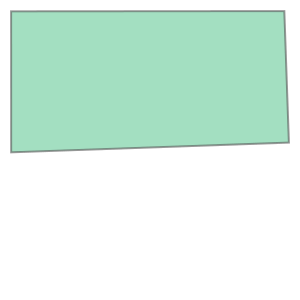

In [19]:
# we manually draw the polygon that contains the common area between the samples
box = landmarks_sdata.shapes["box"]
# let's get the Polygon object out of the GeoDataFrame
box = box.iloc[0][0]
box

The functions below implement spatial queries operations on polygons. These functions will be implemented in SpatialData and the code will become simpler.

In [20]:
from dask.dataframe.core import DataFrame as DaskDataFrame
from geopandas import GeoDataFrame


def points_dask_dataframe_to_geopandas(points: DaskDataFrame) -> GeoDataFrame:
    # let's ignore the z component here
    points_gdf = GeoDataFrame(
        geometry=geopandas.points_from_xy(points["x"], points["y"])
    )
    for c in points.columns:
        points_gdf[c] = points[c]
    return points_gdf


def points_geopandas_to_dask_dataframe(gdf: GeoDataFrame) -> DaskDataFrame:
    # convert the GeoDataFrame to a Dask DataFrame
    ddf = dd.from_pandas(gdf[gdf.columns.drop("geometry")], npartitions=1)
    ddf["x"] = gdf.geometry.x
    ddf["y"] = gdf.geometry.y
    # parse
    ddf = PointsModel.parse(ddf, coordinates={"x": "x", "y": "y"})
    return ddf

In [21]:
%%time
from shapely import Polygon
from spatialdata.models import ShapesModel, PointsModel
from dask.dataframe.core import DataFrame as DaskDataFrame
import dask.dataframe as dd


def spatial_query_shapes_and_points_by_polygon(
    sdata: SpatialData, polygon: Polygon, target_coordinate_system: str
):
    new_shapes = {}
    for shapes_name, shapes in sdata.shapes.items():
        if "__old_index" in shapes.columns:
            assert np.all(shapes["__old_index"] == shapes.index)
        else:
            shapes["__old_index"] = shapes.index
        # indices = shapes.intersects(polygon)
        # indices = shapes.geometry.apply(lambda x: x.intersects(polygon).values.tolist()[0][0])
        indices = shapes.geometry.apply(lambda x: x.intersects(polygon))
        if np.sum(indices) == 0:
            raise ValueError("we expect at least one shape")
        queried_shapes = shapes[indices]
        queried_shapes.index = queried_shapes["__old_index"]
        del shapes["__old_index"]
        del queried_shapes["__old_index"]
        transformation = get_transformation(shapes, target_coordinate_system)
        queried_shapes = ShapesModel.parse(queried_shapes)
        set_transformation(queried_shapes, transformation, target_coordinate_system)
        new_shapes[shapes_name] = queried_shapes

    new_points = {}
    for points_name, points in sdata.points.items():
        # let's ignore the z component here
        points_gdf = points_dask_dataframe_to_geopandas(points)
        # queried_points = points_gdf.intersects(pp)
        indices = points_gdf.geometry.intersects(polygon)
        if np.sum(indices) == 0:
            raise ValueError("we expect at least one point")
        queried_points = points_gdf[indices]
        ddf = points_geopandas_to_dask_dataframe(queried_points)
        new_points[points_name] = ddf

    return SpatialData(shapes=new_shapes, points=new_points, table=sdata.table)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 13.4 µs


In [22]:
%%time
# let's keep only the shapes inside the query polygon (roi)
# and then let's manually filter the table to keep only the rows that are inside the polygon pp
xe_rep1_roi_sdata = spatial_query_shapes_and_points_by_polygon(
    sdata=xe_rep1_transformed_sdata,
    polygon=box,
    target_coordinate_system="aligned",
)

CPU times: user 3min, sys: 1min 7s, total: 4min 7s
Wall time: 3min 55s


In [23]:
merged = pd.merge(
    xe_rep1_roi_sdata.table.obs[["cell_id"]],
    xe_rep1_roi_sdata.shapes["cell_circles"],
    how="right",
    left_on="cell_id",
    right_index=True,
)
filtered_table = xe_rep1_roi_sdata.table[merged.index].copy()
del xe_rep1_roi_sdata.table
xe_rep1_roi_sdata.table = filtered_table

In [24]:
%%time
xe_rep2_roi_sdata = spatial_query_shapes_and_points_by_polygon(
    sdata=xe_rep2_transformed_sdata,
    polygon=box,
    target_coordinate_system="aligned",
)

CPU times: user 2min 51s, sys: 1min 33s, total: 4min 24s
Wall time: 3min 50s


In [25]:
merged = pd.merge(
    xe_rep2_roi_sdata.table.obs[["cell_id"]],
    xe_rep2_roi_sdata.shapes["cell_circles"],
    how="right",
    left_on="cell_id",
    right_index=True,
)
filtered_table = xe_rep2_roi_sdata.table[merged.index].copy()
del xe_rep2_roi_sdata.table
xe_rep2_roi_sdata.table = filtered_table

In [26]:
%%time
visium_roi_sdata = spatial_query_shapes_and_points_by_polygon(
    sdata=visium_transformed_sdata,
    polygon=box,
    target_coordinate_system="aligned",
)

CPU times: user 44.5 ms, sys: 778 µs, total: 45.2 ms
Wall time: 44.7 ms


In [27]:
merged = pd.merge(
    visium_roi_sdata.table.obs[["spot_id"]],
    visium_roi_sdata.shapes["CytAssist_FFPE_Human_Breast_Cancer"],
    how="right",
    left_on="spot_id",
    right_index=True,
)
filtered_table = visium_roi_sdata.table[
    visium_roi_sdata.shapes["CytAssist_FFPE_Human_Breast_Cancer"].index
].copy()
del visium_roi_sdata.table
visium_roi_sdata.table = filtered_table

In [28]:
from copy import copy

sel_genes = list(
    set(visium_roi_sdata.table.var_names) & (set(xe_rep1_roi_sdata.table.var_names))
)

filtered_table = xe_rep1_roi_sdata.table[:, sel_genes].copy()
del xe_rep1_roi_sdata.table
xe_rep1_roi_sdata.table = filtered_table

filtered_table = xe_rep2_roi_sdata.table[:, sel_genes].copy()
del xe_rep2_roi_sdata.table
xe_rep2_roi_sdata.table = filtered_table

filtered_table = visium_roi_sdata.table[:, sel_genes].copy()
del visium_roi_sdata.table
visium_roi_sdata.table = filtered_table

## 1.5. Cell-type interpolation of the visium spots


In [29]:
%%time
visium_spots_polygons = visium_roi_sdata.shapes[
    "CytAssist_FFPE_Human_Breast_Cancer"
].copy()
visium_spots_polygons["geometry"] = visium_spots_polygons.buffer(
    visium_spots_polygons.radius.iloc[0], 128
)

visium_spots_polygons["spot_id"] = visium_spots_polygons.index
xe_rep1_roi_sdata.shapes["cell_boundaries"]["cell_id"] = xe_rep1_roi_sdata.shapes[
    "cell_boundaries"
].index
xe_rep2_roi_sdata.shapes["cell_boundaries"]["cell_id"] = xe_rep2_roi_sdata.shapes[
    "cell_boundaries"
].index

spots_xe_rep1 = visium_spots_polygons.overlay(
    xe_rep1_roi_sdata.shapes["cell_boundaries"], how="intersection"
)
spots_xe_rep2 = visium_spots_polygons.overlay(
    xe_rep2_roi_sdata.shapes["cell_boundaries"], how="intersection"
)

/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CPU times: user 6.81 s, sys: 3.74 ms, total: 6.82 s
Wall time: 6.82 s


In [30]:
from geopandas import GeoDataFrame
from typing import Any


def get_geoseries_types(gdf: GeoDataFrame) -> set[Any]:
    types = set()
    geom = gdf.geometry
    for i in range(len(geom)):
        x = geom.iloc[i]
        types.add(type(x))
    return types

In [31]:
# as you can see from here:
print(len(spots_xe_rep1.cell_id.unique()))
print(len(spots_xe_rep1))
# there are some rows that refer to the same cell.

62383
62532


In [32]:
# Also, some rows are Polygons, others are Multipolygons
print(get_geoseries_types(xe_rep1_roi_sdata.shapes["cell_boundaries"]))
print(get_geoseries_types(visium_spots_polygons))
print(get_geoseries_types(spots_xe_rep1))

{<class 'shapely.geometry.polygon.Polygon'>}
{<class 'shapely.geometry.polygon.Polygon'>}
{<class 'shapely.geometry.multipolygon.MultiPolygon'>, <class 'shapely.geometry.polygon.Polygon'>}


In [33]:
# The first are cells that touch multiple Visium circles. The second are cells that intersect the same Visium circles in multiple points.

Each spot is deconvolved based on the intersected areas with the xenium cells. We do this for both repolicates and at the minor and major cell type levels. 

In [48]:
from sklearn.preprocessing import OneHotEncoder

spots_xe_rep1["area"] = spots_xe_rep1["geometry"].area
ss = spots_xe_rep1.pivot_table(
    index=["spot_id"], columns="cell_id", values="area", aggfunc="sum"  # add margins
).fillna(0)
ss_raw = ss.copy()
ss = ss.div(ss.sum(axis=1), axis=0)

missing_spots = list(set(visium_spots_polygons["spot_id"]).difference(set(ss.index)))
ms_df = pd.DataFrame([[0] * ss.shape[1]], columns=ss.columns, index=missing_spots)

ss = ss.append(ms_df)
ss = ss.loc[visium_roi_sdata.table.obs["spot_id"]]

ss_raw = ss_raw.append(ms_df)
ss_raw = ss_raw.loc[visium_roi_sdata.table.obs["spot_id"]]

/tmp/ipykernel_87870/772322310.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss = ss.append(ms_df)
/tmp/ipykernel_87870/772322310.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss_raw = ss_raw.append(ms_df)


In [49]:
area_cells = xe_rep1_roi_sdata.shapes["cell_boundaries"][
    xe_rep1_roi_sdata.shapes["cell_boundaries"].index.isin(ss_raw.columns.tolist())
].geometry.area

A = ss_raw.div(area_cells, axis=1)
B = xe_rep1_sdata.table[xe_rep1_sdata.table.obs.cell_id.isin(ss.columns.tolist())]

sparse_A = sparse.csr_matrix(A)
C = sparse_A @ B.X
# gene expression interpolating Xenium cells gene expression into Visium circles
visium_gene_expression_from_xenium_cells_rep1 = anndata.AnnData(
    C.toarray(), var=xe_rep1_sdata.table.var
)

/tmp/ipykernel_87870/1569935777.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  visium_gene_expression_from_xenium_cells_rep1 = anndata.AnnData(


In [50]:
ohe = OneHotEncoder()
major_one = ohe.fit_transform(
    xe_rep1_sdata.table[list(ss.columns), :].obs[["celltype_major"]]
)
spot_xe_rep1_types = ss.to_numpy() @ major_one
visium_roi_sdata.table.copy().obsm["xe_rep1_celltype_major"] = spot_xe_rep1_types

ohe = OneHotEncoder()
minor_one = ohe.fit_transform(
    xe_rep1_sdata.table[list(ss.columns), :].obs[["celltype_minor"]]
)
spot_xe_rep1_types = ss.to_numpy() @ minor_one
visium_roi_sdata.table.obsm["xe_rep1_celltype_minor"] = spot_xe_rep1_types

In [51]:
spots_xe_rep2["area"] = spots_xe_rep2["geometry"].area
ss = spots_xe_rep2.pivot_table(
    index=["spot_id"], columns="cell_id", values="area", aggfunc="sum"  # add margins
).fillna(0)
ss_raw = ss.copy()
ss = ss.div(ss.sum(axis=1), axis=0)

missing_spots = list(set(visium_spots_polygons["spot_id"]).difference(set(ss.index)))
ms_df = pd.DataFrame([[0] * ss.shape[1]], columns=ss.columns, index=missing_spots)

ss = ss.append(ms_df)
ss = ss.loc[visium_roi_sdata.table.obs["spot_id"]]

ss_raw = ss_raw.append(ms_df)
ss_raw = ss_raw.loc[visium_roi_sdata.table.obs["spot_id"]]

/tmp/ipykernel_87870/4027164512.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss = ss.append(ms_df)
/tmp/ipykernel_87870/4027164512.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ss_raw = ss_raw.append(ms_df)


In [52]:
area_cells = xe_rep2_roi_sdata.shapes["cell_boundaries"][
    xe_rep2_roi_sdata.shapes["cell_boundaries"].index.isin(ss_raw.columns.tolist())
].geometry.area

A = ss_raw.div(area_cells, axis=1)
B = xe_rep2_sdata.table[xe_rep2_sdata.table.obs.cell_id.isin(ss.columns.tolist())]

sparse_A = sparse.csr_matrix(A)
C = sparse_A @ B.X
# gene expression interpolating Xenium cells gene expression into Visium circles
visium_gene_expression_from_xenium_cells_rep2 = anndata.AnnData(
    C.toarray(), var=xe_rep2_sdata.table.var
)

/tmp/ipykernel_87870/2847905008.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  visium_gene_expression_from_xenium_cells_rep2 = anndata.AnnData(


In [53]:
ohe = OneHotEncoder()
major_one = ohe.fit_transform(
    xe_rep2_sdata.table[list(ss.columns), :].obs[["celltype_major"]]
)
spot_xe_rep2_types = ss.to_numpy() @ major_one
visium_roi_sdata.table.obsm["xe_rep2_celltype_major"] = spot_xe_rep2_types

ohe = OneHotEncoder()
minor_one = ohe.fit_transform(
    xe_rep2_sdata.table[list(ss.columns), :].obs[["celltype_minor"]]
)
spot_xe_rep2_types = ss.to_numpy() @ minor_one
visium_roi_sdata.table.obsm["xe_rep2_celltype_minor"] = spot_xe_rep2_types

## 1.6. Expression interpolation of the visium spots 
Same story as for the cell types but for the transcripts from `xe_rep1` and `xe_rep2`. 

In [54]:
%%time
xe_rep1_tx_roi = points_dask_dataframe_to_geopandas(
    xe_rep1_roi_sdata.points["transcripts"]
)
xe_rep2_tx_roi = points_dask_dataframe_to_geopandas(
    xe_rep2_roi_sdata.points["transcripts"]
)

CPU times: user 38.3 s, sys: 1min 5s, total: 1min 43s
Wall time: 1min 44s


In [55]:
%%time
spots_xe_rep1_tx = xe_rep1_tx_roi.overlay(visium_spots_polygons, how="intersection")

CPU times: user 3min 15s, sys: 2.22 s, total: 3min 17s
Wall time: 3min 17s


In [56]:
%%time
spots_xe_rep2_tx = xe_rep2_tx_roi.overlay(visium_spots_polygons, how="intersection")

CPU times: user 3min 6s, sys: 3.3 s, total: 3min 9s
Wall time: 3min 9s


In [57]:
# TODO fix bug with feature_name: https://github.com/scverse/spatialdata-io/issues/25
spots_xe_rep1_tx["feature_name"] = [
    gene[2:-1] for gene in spots_xe_rep1_tx["feature_name"]
]
spots_xe_rep2_tx["feature_name"] = [
    gene[2:-1] for gene in spots_xe_rep2_tx["feature_name"]
]

Note that for some spots we don't have any transcripts interpolated. 

In [58]:
spots_xe_rep1_counts = spots_xe_rep1_tx.pivot_table(
    index=["spot_id"],
    columns="feature_name",
    values="radius",  # add margins
    aggfunc="sum",
).fillna(0)
missing_spots = list(
    set(visium_spots_polygons["spot_id"]).difference(set(spots_xe_rep1_counts.index))
)
ms_df = pd.DataFrame(
    [[0] * spots_xe_rep1_counts.shape[1]],
    columns=spots_xe_rep1_counts.columns,
    index=missing_spots,
)
spots_xe_rep1_counts = spots_xe_rep1_counts.append(ms_df)
spots_xe_rep1_counts = spots_xe_rep1_counts.loc[visium_roi_sdata.table.obs["spot_id"]]
spots_xe_rep1_counts = spots_xe_rep1_counts[sel_genes].to_numpy()
visium_roi_sdata.table.layers["xe_rep1_tx"] = spots_xe_rep1_counts

/tmp/ipykernel_87870/3190220434.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spots_xe_rep1_counts = spots_xe_rep1_counts.append(ms_df)


In [59]:
visium_roi_sdata.table.layers[
    "xe_rep1_cells"
] = visium_gene_expression_from_xenium_cells_rep1[:, sel_genes].X.copy()

In [60]:
spots_xe_rep2_counts = spots_xe_rep2_tx.pivot_table(
    index=["spot_id"],
    columns="feature_name",
    values="radius",  # add margins
    aggfunc="sum",
).fillna(0)
missing_spots = list(
    set(visium_spots_polygons["spot_id"]).difference(set(spots_xe_rep2_counts.index))
)
ms_df = pd.DataFrame(
    [[0] * spots_xe_rep2_counts.shape[1]],
    columns=spots_xe_rep2_counts.columns,
    index=missing_spots,
)
spots_xe_rep2_counts = spots_xe_rep2_counts.append(ms_df)
spots_xe_rep2_counts = spots_xe_rep2_counts.loc[visium_roi_sdata.table.obs["spot_id"]]
spots_xe_rep2_counts = spots_xe_rep2_counts[sel_genes].to_numpy()
visium_roi_sdata.table.layers["xe_rep2_tx"] = spots_xe_rep2_counts

/tmp/ipykernel_87870/503191660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spots_xe_rep2_counts = spots_xe_rep2_counts.append(ms_df)


In [61]:
visium_roi_sdata.table.layers[
    "xe_rep2_cells"
] = visium_gene_expression_from_xenium_cells_rep2[:, sel_genes].X.copy()

In [62]:
xe_rep1_roi_sdata

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (100849, 2) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (100444, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (100646, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 100444 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (100444, 307)
with coordinate systems:
▸ 'aligned', with elements:
        cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        transcripts (Points)

In [63]:
xe_rep2_roi_sdata

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (99923, 2) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (99635, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (99761, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 99635 × 307
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (99635, 307)
with coordinate systems:
▸ 'aligned', with elements:
        cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        transcripts (Points)

In [64]:
visium_roi_sdata

SpatialData object with:
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (2775, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2775 × 307
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_tx', 'xe_rep1_cells', 'xe_rep2_tx', 'xe_rep2_cells': AnnData (2775, 307)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer (Shapes)

In [65]:
# save transformations to disk (it was only in-memory so far)
# TODO: we have to make this more ergonomic and transparent (in the spatiadata package)


def save_all_transformations(sdata: SpatialData) -> None:
    for element in sdata._gen_elements_values():
        transformations = get_transformation(element, get_all=True)
        set_transformation(element, transformations, set_all=True, write_to_sdata=sdata)


save_all_transformations(xe_rep1_sdata)
save_all_transformations(xe_rep2_sdata)
save_all_transformations(visium_sdata)

In [66]:
# the table of the xenium data was modified only in-memory, let's sync the change to disk
# TODO: also this needs to be improved


def save_table(sdata: SpatialData) -> None:
    table = sdata.table
    del sdata.table
    # this is triggering the writing to disk, it is not intuitive
    sdata.table = table


save_table(xe_rep1_sdata)
save_table(xe_rep2_sdata)
save_table(visium_sdata)

/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'maxshape'
  warn('ignoring keyword argument %r' % k)


In [67]:
# delete column in shapes data that we don't want to save (it just duplicates the index and we used before some merging that will be replaced by aggregate())
del xe_rep1_roi_sdata.shapes["cell_boundaries"]["cell_id"]
del xe_rep2_roi_sdata.shapes["cell_boundaries"]["cell_id"]

In [68]:
%%time
import shutil

if os.path.isdir(XE_REP1_ROI_PATH):
    shutil.rmtree(XE_REP1_ROI_PATH)
xe_rep1_roi_sdata.write(XE_REP1_ROI_PATH)

if os.path.isdir(XE_REP2_ROI_PATH):
    shutil.rmtree(XE_REP2_ROI_PATH)
xe_rep2_roi_sdata.write(XE_REP2_ROI_PATH)

if os.path.isdir(VISIUM_ROI_PATH):
    shutil.rmtree(VISIUM_ROI_PATH)
visium_roi_sdata.write(VISIUM_ROI_PATH)

/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'maxshape'
  warn('ignoring keyword argument %r' % k)


CPU times: user 9.9 s, sys: 5.64 s, total: 15.5 s
Wall time: 15.5 s


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:250: UserWarning: ignoring keyword argument 'maxshape'
  warn('ignoring keyword argument %r' % k)


In [69]:
xe_rep1_sdata2 = sd.read_zarr(XE_REP1_PATH)
xe_rep2_sdata2 = sd.read_zarr(XE_REP2_PATH)
visium_sdata2 = sd.read_zarr(VISIUM_PATH)

xe_rep1_roi_sdata2 = sd.read_zarr(XE_REP1_ROI_PATH)
xe_rep2_roi_sdata2 = sd.read_zarr(XE_REP2_ROI_PATH)
visium_roi_sdata2 = sd.read_zarr(VISIUM_ROI_PATH)

INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            
INFO     Instance key `cell_id` could be of type `pd.Categorical`. Consider casting it.                            


In [70]:
assert str(xe_rep1_sdata) == str(xe_rep1_sdata2)
assert str(xe_rep2_sdata) == str(xe_rep2_sdata2)
assert str(visium_sdata) == str(visium_sdata2)

assert str(xe_rep1_roi_sdata) == str(xe_rep1_roi_sdata2)
assert str(xe_rep2_roi_sdata) == str(xe_rep2_roi_sdata2)
assert sorted(str(visium_roi_sdata)) == sorted(str(visium_roi_sdata2))

In [71]:
XE_REP1_ALIGNED_PATH = XE_REP1_PATH.replace("data.zarr", "data_aligned.zarr")
XE_REP2_ALIGNED_PATH = XE_REP2_PATH.replace("data.zarr", "data_aligned.zarr")
VISIUM_ALIGNED_PATH = VISIUM_PATH.replace("data.zarr", "data_aligned.zarr")

if os.path.isdir(XE_REP1_ALIGNED_PATH):
    shutil.rmtree(XE_REP1_ALIGNED_PATH)
    shutil.copytree(XE_REP1_PATH, XE_REP1_ALIGNED_PATH)

if os.path.isdir(XE_REP2_ALIGNED_PATH):
    shutil.rmtree(XE_REP2_ALIGNED_PATH)
    shutil.copytree(XE_REP2_PATH, XE_REP2_ALIGNED_PATH)

if os.path.isdir(VISIUM_ALIGNED_PATH):
    shutil.rmtree(VISIUM_ALIGNED_PATH)
    shutil.copytree(VISIUM_PATH, VISIUM_ALIGNED_PATH)